
# Examen OPI
# Respondido por: Marco Tulio Pérez Ortega

# Problema 1. Sesión A. Carpeta de investigación PGJ.



In [468]:
pip install prince

Note: you may need to restart the kernel to use updated packages.


In [654]:
#Librerias que utilizaremos para responder las preguntas
#Manejo de base de datos
import pandas as pd
#Regresión lineal
from sklearn import linear_model
#Visualización
import matplotlib.pylab as plt 
import seaborn as sns
#Operaciones matemáticas y matriciales
import numpy as np
#Pruebas estadísticas
from scipy.stats import t
#Análisis de correspondencia
import prince
from sklearn.neighbors import NearestNeighbors
# Análisis de factores
from sklearn.decomposition import FactorAnalysis


In [419]:
#Cargamos datos
datos=pd.read_csv('datos.csv')
datos['fecha']=pd.to_datetime(datos.fecha_hechos).dt.date
datos['mes_num']=pd.to_datetime(datos.fecha_hechos).dt.month
datos['fecha_mes']=datos.ao_hechos+datos.mes_num/12

#En el inciso c veremos que se reportan municipios de la republica mexicana por lo que solo nos quedaremos con alcaldías
alcaldias=sub_datos.groupby('alcaldia_hechos',sort=True).count()['ao_hechos'].sort_values(ascending=False)[:16].index
datos.index=datos['alcaldia_hechos']
datos=datos.loc[alcaldias]


C:\Users\under\.conda\envs\arcade\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [340]:
#Datos nulos por columna 
for column in datos.columns:
    print(column,sum(datos[column].isnull()))

ao_hechos 422
mes_hechos 422
fecha_hechos 422
ao_inicio 0
mes_inicio 0
fecha_inicio 3
delito 0
fiscalia 2
agencia 0
unidad_investigacion 224
categoria_delito 0
calle_hechos 2735
calle_hechos2 767258
colonia_hechos 39016
alcaldia_hechos 0
competencia 1053049
longitud 38039
latitud 38039
tempo 1255302
fecha 422
mes_num 422
fecha_mes 422


## Pruebas para validar la calidad de los datos

La calidad de los datos puede ser disminuida por diferentes razones, desde errores humanos al capturar información, hasta eventos que pueden considerarse atípicos. Las pruebas que propongo  para validar la caildad de estos datos son:

    •Verificar la Normalidad de datos. Podemos verificar que la distribución de la frecuenca de delitos en un intervalo de tiempo, por ejemplo mensual sigue una distribución normal esto puede verificarse de  forma visual con qq - plots o histogramas, o analítica mediante las pruebas estadísticas como  Kolmogorov-Smirnov, la ji cuadra  de Pearson o la prueba de  Jarque-Bera.
    
    •Identificar datos atípicos. Podemos indetificar datos atípicos mediante con ayuda de las medidas de tendencia central, (media, mediana, moda) y medidas de disperción (desviación estándar).
    • Identificar columnas con datos faltantes.
    
    •Visualizaciones. En este caso particular, debido a que la mayoria de las variables son categóricas, las gráficas de dispersión pueden ser de bastante utilidad.  Por ejemplo en la siguiente gráfica se presenta el número de delitos reportados por mes y año. 

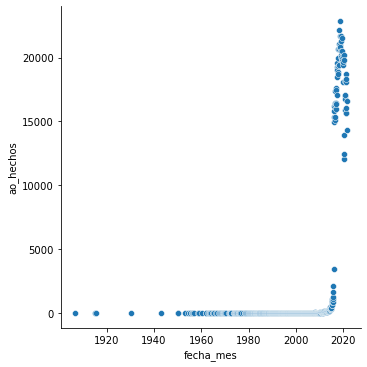

In [341]:
x=datos.groupby('fecha_mes').count()
sns.relplot(data=x,x=x.index,y='ao_hechos')

En la gráfica anterior podemos notar que el reporte de delitos se dispara después del 2010, no debemos asumir que el número de delitos ha aumentado a partir de este año, ya que debemos tomar en cuenta los procesos que se seguían antes de 2010 para reportar delitos si es que se intentaban  a reportar, otro aspecto que debe ser considerado es la tecnología que se contaba, por ejemplo en 1980 para reportar delitos contra la tecnología con la que se cuenta en nuestros días, lo que quiero destacar con esta comparación es que pueden existir bastantes reportes delictivos esperando ser digitalizados. 
Veamos la gráfica un poco más de cerca.

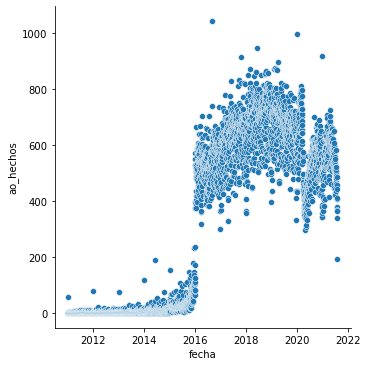

In [342]:
sub_datos=datos[datos.ao_hechos>2010]
x=sub_datos.groupby('fecha').count()
sns.relplot(data=x,x=x.index,y='ao_hechos')

En la gráfica anterior podemos observar que aún existe una brecha bastante clara entre 2015 y 2016, por lo que para responder a la segunda pregunta solo usaremos datos de 2016 hacia adelante.

## Delitos a la alza y a la baja.
Se tiene un total de 341 delitos diferentes, para identificar cuales van a la alza y cuales a la baja, nos apoyaremos en el método de regresión clásico para obtener un $\beta$ que nos indique que delito esta a la alta $\beta>0$ y cual a la baja $\beta<0$. La metodología para decidir si un delito está a la alza o  a la baja es el siguiente:

1. Para cada tipo de delito se calcula la regresión lineal tomando como variable explicativa mes y año y como variable explicada el número de delitos reportados ese mes.

2. Se verifica que el beta obtenido sea estadísticamente significativo.
    
3. Se verifica que el modelo este moderadamente explicado por la variable tiempo ($R^{2}>.5$)
    
4. Para evitar modelos obtenidos mediante muestras poco significativas, tomamos solo delitos  con menos de 12 meses reportados en cero, esta medida tambié evita considerar delitos que probablemente hayan cambiado de nombre, como por ejemplo **ABUSO DE AUTORIDAD** y **ABUSO DE AUTORIDAD Y USO ILEGAL DE LA FUERZA PUBLICA**  cuyas gráficas se muestran a continuación.




<AxesSubplot:ylabel='ABUSO DE AUTORIDAD'>

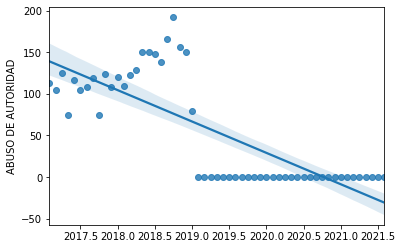

In [343]:
sns.regplot(x=list(panel.columns),y=panel.loc['ABUSO DE AUTORIDAD'])

<AxesSubplot:ylabel='ABUSO DE AUTORIDAD Y USO ILEGAL DE LA FUERZA PUBLICA'>

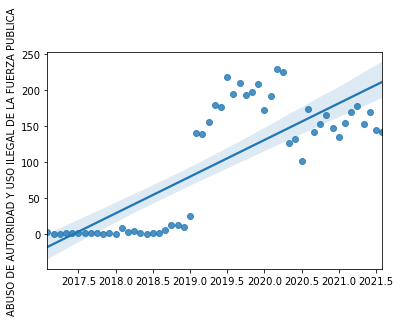

In [344]:
sns.regplot(x=list(panel.columns),y=panel.loc['ABUSO DE AUTORIDAD Y USO ILEGAL DE LA FUERZA PUBLICA'])

Manejar este tipo de casos resulta un tanto más laborioso por lo que por el momento no se serán considerados.

In [345]:
sub_datos=datos[datos.ao_hechos>2016]
panel=pd.pivot_table(data=sub_datos,columns='fecha_mes',index='delito',values='ao_inicio',aggfunc='count',fill_value=0)
print('Número del tipo de delitos diferentes:', panel.shape[0])

Número del tipo de delitos diferentes: 340


In [346]:
#Función que obtiene los estimadores del análisis de regresión
def get_regression(x,y):
    p=x.shape[1]+1
    n=x.shape[0]
    #Diferencia cuadrática en x
    SS_x=sum((x-np.mean(x))**2)
    #Estimación
    lm=linear_model.LinearRegression()
    lm.fit(x,y)
    y_hat=lm.predict(x)
    #Error
    error=y-y_hat
    beta=lm.coef_[0]
    R=lm.score(x,y)
    
    #Error cuadrático medio
    mse=sum(error**2)/(n-p)
    std_error=np.sqrt(mse/(SS_x))[0]
    #Valores de decisión
    t_value=beta/std_error
    p_value=1-t.cdf(np.abs(t_value),df=65)
    return y_hat,beta,R,mse,std_error,t_value,p_value
    

In [347]:
lm=linear_model.LinearRegression()
n=(len(panel.columns))
x=np.array(list(panel.columns)).reshape(n,1)
scores={}
for i in range(len(panel.index)):
    delito=panel.index[i]
    #Frecuencia del delito
    frec=sum(panel.loc[delito])
    info={}
    #frecuencia distribuida en el tiempo
    y=panel.loc[delito]
    #Contamos ceros
    n_ceros=sum(y==0)
    #Regresión lineal
    y_hat,beta,R,mse,std_error,t_value,p_value=get_regression(x,y)
    #Guardamos información
    info['beta']=beta
    info['R']=R
    info['casos']=frec
    info['ceros']=n_ceros
    info['mse']=mse
    info['Std. error']=std_error
    info['t_value']=t_value
    info['p_val']=p_value
    info['indicador']=(n_ceros<12)&(p_value<.05)&(R>.5)
    scores[delito]=info
#Creamos data frame
results=pd.DataFrame.from_dict(scores,orient='index')

In [348]:
#Observamos a results
results.head()

,beta,R,casos,ceros,mse,Std. error,t_value,p_val,indicador
ABANDONO DE PERSONA,-17.159307,0.757686,1222,31,171.006713,1.332927,-12.873408,0.000000e+00,False
ABORTO,-0.195671,0.007235,452,0,9.541447,0.314852,-0.621469,2.682322e-01,False
ABUSO DE AUTORIDAD,-37.555844,0.602901,2966,31,1687.070216,4.186646,-8.970390,2.793321e-13,False
ABUSO DE AUTORIDAD Y USO ILEGAL DE LA FUERZA PUBLICA,50.569697,0.631973,5278,5,2704.497275,5.300818,9.539980,2.797762e-14,True
ABUSO DE CONFIANZA,-12.455411,0.239435,16918,0,894.929015,3.049256,-4.084737,6.170536e-05,False


In [349]:
crecientes=results[(results.indicador==True)&(results.beta>0)].index
decrecientes=results[(results.indicador==True)&(results.beta<0)].index

**A continuación listamos el los delitos que parecen ir a la alza**.

In [350]:
results[(results.indicador==True)&(results.beta>0)]

,beta,R,casos,ceros,mse,Std. error,t_value,p_val,indicador
ABUSO DE AUTORIDAD Y USO ILEGAL DE LA FUERZA PUBLICA,50.569697,0.631973,5278,5,2704.497275,5.300818,9.539980,2.797762e-14,True
ACOSO SEXUAL,19.122944,0.584762,3285,0,471.576181,2.213480,8.639313,1.072586e-12,True
AMENAZAS,137.678788,0.599389,58064,0,23007.724805,15.460960,8.904931,3.641532e-13,True
CONTRA EL CUMPLIMIENTO DE LA OBLIGACION ALIMENTARIA,7.429437,0.551943,1253,0,81.371983,0.919469,8.080139,1.051481e-11,True
DAÑO EN PROPIEDAD AJENA INTENCIONAL A CASA HABITACION,7.769697,0.562080,2102,0,85.414027,0.942029,8.247833,5.297762e-12,True
"NARCOMENUDEO POSESIÓN CON FINES DE VENTA, COMERCIO Y SUMINISTRO",16.332468,0.513339,4894,0,459.251752,2.184364,7.476989,1.239475e-10,True
ROBO A PASAJERO A BORDO DE TRANSPORTE PÚBLICO SIN VIOLENCIA,9.587013,0.755618,1674,0,53.983227,0.748909,12.801306,0.000000e+00,True
ROBO A TRANSEUNTE EN PARQUES Y MERCADOS CON VIOLENCIA,20.303030,0.744781,1689,0,256.525291,1.632543,12.436442,0.000000e+00,True
ROBO DE PLACA DE AUTOMOVIL,24.352381,0.810245,3988,0,252.222526,1.618794,15.043534,0.000000e+00,True
TENTATIVA DE EXTORSION,30.266667,0.615668,8502,0,1038.519573,3.284785,9.214200,1.040279e-13,True


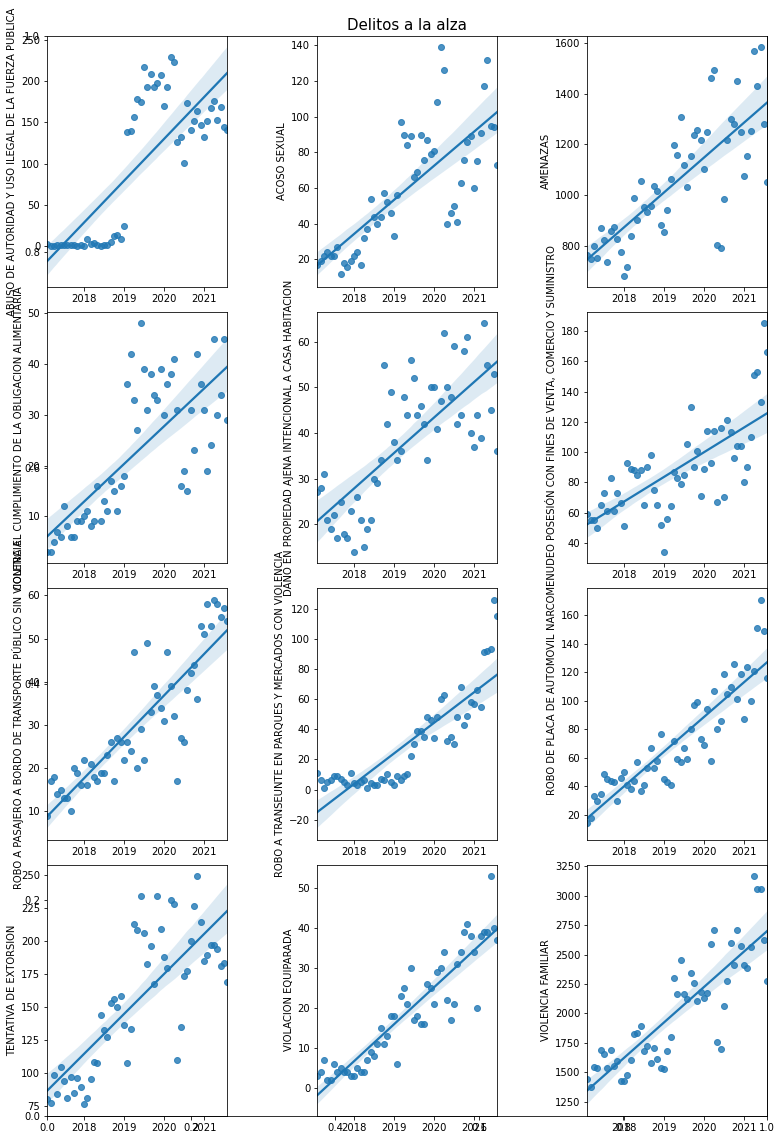

In [355]:
fig = plt.figure(figsize=(10,15)) 
plt.title('Delitos a la alza', size=15)
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.1, wspace=0.5) 
for j,delito in enumerate(crecientes): 
    ax = fig.add_subplot(4, 3, j+1) 
    sns.regplot(x=list(panel.columns),y=panel.loc[delito],ax=ax) 
    

**A continuación listamos el los delitos que parecen ir a la baja**.


In [353]:
results[(results.indicador==True)&(results.beta<0)]

,beta,R,casos,ceros,mse,Std. error,t_value,p_val,indicador
CONTRA FUNCIONARIOS PUBLICOS,-6.826840,0.701158,741,4,36.073706,0.612202,-11.151280,1.110223e-16,True
DAÑO EN PROPIEDAD AJENA INTENCIONAL,-22.868398,0.502309,11359,0,940.989789,3.126742,-7.313810,2.414008e-10,True
DELITOS AMBIENTALES,-17.434632,0.541666,2360,0,467.090189,2.202926,-7.914305,2.072031e-11,True
LESIONES INTENCIONALES,-19.619048,0.572116,2868,0,522.783675,2.330562,-8.418162,2.642442e-12,True
LESIONES INTENCIONALES POR ARMA DE FUEGO,-27.550649,0.704901,6593,0,577.069333,2.448576,-11.251702,0.000000e+00,True
ROBO A CASA HABITACION SIN VIOLENCIA,-79.139394,0.606991,24366,0,7364.283553,8.747116,-9.047484,2.042810e-13,True
ROBO A NEGOCIO SIN VIOLENCIA,-276.098701,0.625250,53193,0,82973.771674,29.360946,-9.403604,4.851675e-14,True
ROBO A TRANSEUNTE DE CELULAR SIN VIOLENCIA,-116.036364,0.628281,8016,5,14466.873756,12.259901,-9.464706,3.785861e-14,True
ROBO DE DINERO,-38.538528,0.743534,6165,0,930.345253,3.109007,-12.395767,0.000000e+00,True
ROBO DE DOCUMENTOS,-19.037229,0.643241,4801,0,365.033875,1.947450,-9.775467,1.088019e-14,True


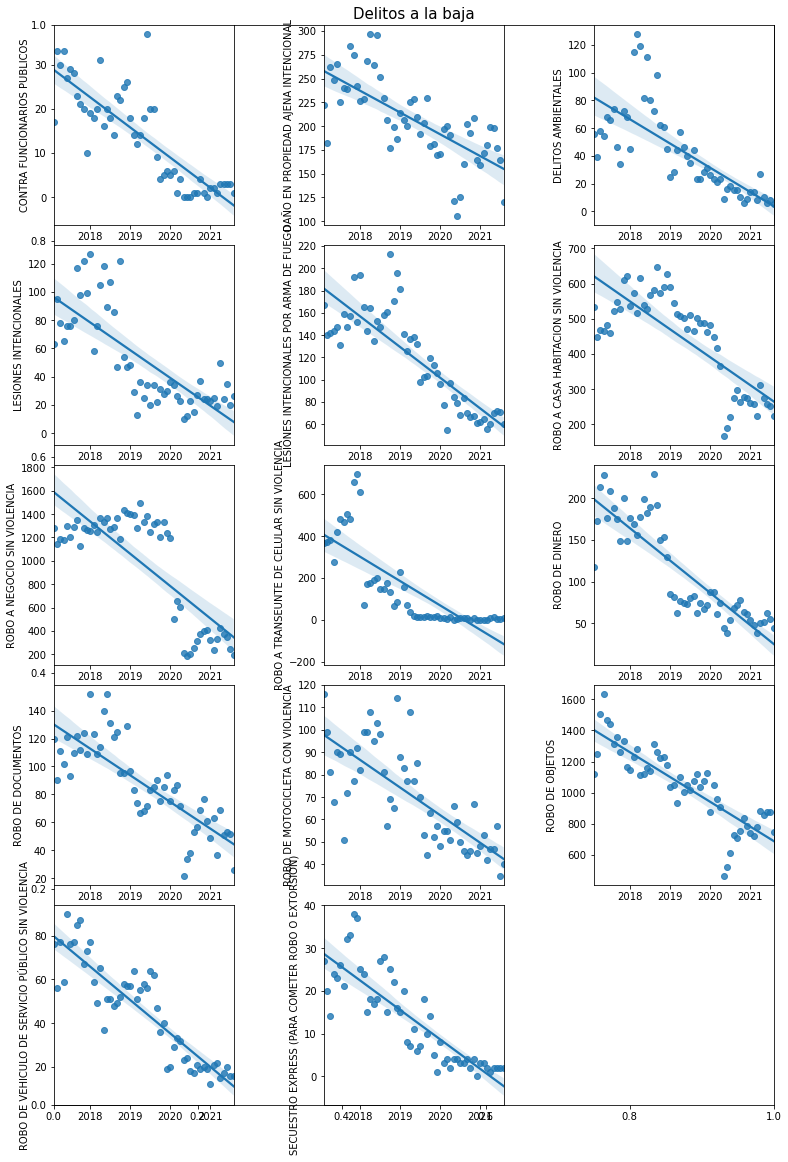

In [354]:
fig = plt.figure(figsize=(10,15)) 
plt.title('Delitos a la baja', size=15)
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.1, wspace=0.5) 
for j,delito in enumerate(decrecientes): 
    ax = fig.add_subplot(5, 3, j+1) 
    sns.regplot(x=list(panel.columns),y=panel.loc[delito],ax=ax) 

## Delitos por alcaldía 
Hemos notado que se reportan distintos municipios de la republica mexicana por lo que realizamos un filtrado para solo tener los reportes ocurridos en las alcaldías de la CDMX. Para realizar esto aprovecharemos que la mayoria de los hechos ocurren en las 16 alcaldías por lo que solo basta ordenar las alcaldías por número de eventos ocurridos.


## Histórico

In [362]:
datos.index=list(range(datos.shape[0]))
alcaldias=datos.groupby('alcaldia_hechos',sort=True).count()['ao_hechos'].sort_values(ascending=False)
alcaldias

alcaldia_hechos
CUAUHTEMOC                197534
IZTAPALAPA                190649
GUSTAVO A MADERO          127183
BENITO JUAREZ             104715
ALVARO OBREGON             86161
COYOACAN                   84759
MIGUEL HIDALGO             82293
TLALPAN                    74383
VENUSTIANO CARRANZA        72874
AZCAPOTZALCO               61574
IZTACALCO                  52677
XOCHIMILCO                 39936
TLAHUAC                    31354
LA MAGDALENA CONTRERAS     20829
CUAJIMALPA DE MORELOS      18814
MILPA ALTA                  9145
Name: ao_hechos, dtype: int64

Históricamente la alcaldía con mayor número de delitos reportados es la Cuauhtemoc, por otro lado Milpa Alta destaca con el menor numéro de delitos reportados, debemos reportar que la delegación Cuauhtemoc es una de las más famosas y tránsitadas de la Ciudad de México, lo que puede verse reflejarse en el número de delitos registrados, por otro lado Milpa Alta al tener pocas zonas cercanas al área metropolitana no registra una gran catidad de delitos. A continuación presentamos resultados solo tomando de 2016 en adelante para tener una persepectiva más contemporánea.

## Contemporáneo 

In [364]:
sub_datos=datos[datos.ao_hechos>2016]
alcaldias=sub_datos.groupby('alcaldia_hechos',sort=True).count()['ao_hechos'].sort_values(ascending=False)
alcaldias

alcaldia_hechos
IZTAPALAPA                158317
CUAUHTEMOC                157617
GUSTAVO A MADERO          106088
BENITO JUAREZ              85367
ALVARO OBREGON             72479
COYOACAN                   69487
MIGUEL HIDALGO             67697
TLALPAN                    61285
VENUSTIANO CARRANZA        60853
AZCAPOTZALCO               50376
IZTACALCO                  43792
XOCHIMILCO                 32930
TLAHUAC                    26690
LA MAGDALENA CONTRERAS     17389
CUAJIMALPA DE MORELOS      15533
MILPA ALTA                  7863
Name: ao_hechos, dtype: int64

Observamos que la alcaldía con mayor número de crimenes reportado es **Iztapalapa**, mientras que **Milpa Alta** aparece con el menor número de delitos reportados. Parece  que un factor importante que influye en el número de delitos es el número de habitantes en cada alcaldía ya que la alcaldía con mayor número de delitos reportados es también la que ostenta más habitantes (1,835,486 hab.) de igual forma  la alcaldía con menor número de delitos reportados es también la que ostenta menos habitantes (152,685 hab.)

## Tendencias estacionales.

Agregamos algunas variables a nuestra base.

In [402]:
datos.columns

Index(['ao_hechos', 'mes_hechos', 'fecha_hechos', 'ao_inicio', 'mes_inicio',
       'fecha_inicio', 'delito', 'fiscalia', 'agencia', 'unidad_investigacion',
       'categoria_delito', 'calle_hechos', 'calle_hechos2', 'colonia_hechos',
       'alcaldia_hechos', 'competencia', 'longitud', 'latitud', 'tempo',
       'fecha', 'mes_num', 'fecha_mes', 'n_dias', 'Dia_semana', 'Dia_mes'],
      dtype='object')

In [420]:
#Número de dias que tiene cada mes
dias_mes={'n_dias':{'Enero':31,'Febrero':28.25,'Marzo':31,'Abril':30,'Mayo':31,'Junio':30,'Julio':31,'Agosto':31,
          'Septiembre':30,'Octubre':31,'Noviembre':30,'Diciembre':31}}
dias_mes=pd.DataFrame.from_dict(dias_mes)
datos.index=datos['mes_hechos']
datos=datos.join(dias_mes)

In [421]:
#Día de la semana 
datos['Dia_semana']=datos['fecha'].apply(lambda x: x.weekday())

In [439]:
# Día del mes
datos['Dia_mes']=datos['fecha'].apply(lambda x: x.day)

**Tendencia por mes.** 

A continuación presentamos  una gráficas que nos permitirá observar en que mes se registran más delitos. Dado que cada mes tiene diferente número de días, el número de delitos por mes será dividido entre el número de días que tiene ese mes, **se considerará 28.25 para febrero debido a los años bisiestos** .

In [424]:
info_mes=pd.pivot_table(data=datos,
                        index=['mes_hechos','ao_hechos'],values='ao_inicio',aggfunc='count',fill_value=0)
info_mes=info_mes.reset_index()
info_mes.index=info_mes.mes_hechos
info_mes=info_mes.join(dias_mes)
#Para observar el comportamiento neto por día
info_mes['rate']=info_mes['ao_inicio']/info_mes['n_dias']

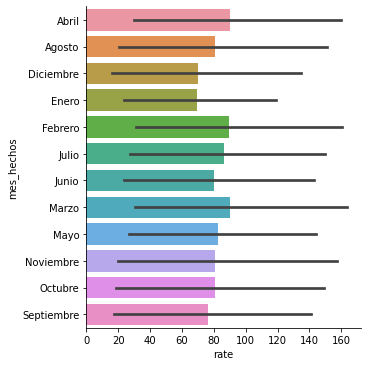

In [425]:
sns.catplot(data=info_mes,y='mes_hechos',x='rate',kind='bar')

In [427]:
info_mes.groupby('mes_hechos').mean()['rate'].sort_values(ascending=False)

mes_hechos
Abril         90.216239
Marzo         90.043779
Febrero       89.668656
Julio         86.519355
Mayo          82.393695
Agosto        80.828784
Noviembre     80.550000
Octubre       80.450039
Junio         79.755556
Septiembre    76.019841
Diciembre     70.020255
Enero         69.620493
Name: rate, dtype: float64

**Observamos** que el periodo que va de febrero a abril el reporta el mayor número de delitos, por otro lado, el periodo  diciembre-enero
es en el que se reportan menos delitos, al parecer los delitos disminuyen en épocas decembrinas, pero hacia febrero comienza a haber un repunto en los delitos. 

**Tendencia por día de la semana**

Ahora realizaremos el mismo proceso para visualizar los delitos por día de la semana.

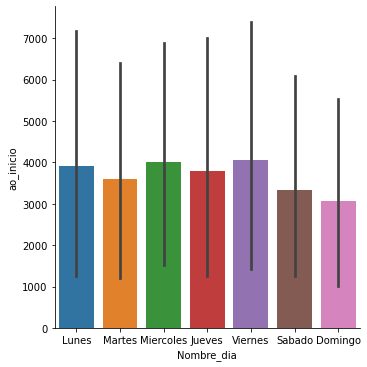

In [433]:
nombre_dia=pd.DataFrame.from_dict({'Nombre_dia':{0:'Lunes',1:'Martes',2:'Miercoles',
                                             3:'Jueves',4:'Viernes',5:'Sabado',6:'Domingo'}})
info_dia=pd.pivot_table(data=datos,index=['Dia_semana','ao_hechos'],values='ao_inicio',aggfunc='count',fill_value=0)
info_dia=info_dia.reset_index()
info_dia.index=info_dia.Dia_semana
info_dia=info_dia.join(nombre_dia)                                  
sns.catplot(data=info_dia,x='Nombre_dia',y='ao_inicio',kind='bar')

In [434]:
info_dia.groupby('Nombre_dia').mean()['ao_inicio'].sort_values(ascending=False)

Nombre_dia
Viernes      4069.520833
Miercoles    4003.574468
Lunes        3912.020833
Jueves       3782.938776
Martes       3590.192308
Sabado       3343.244898
Domingo      3077.604167
Name: ao_inicio, dtype: float64

**Observaciones**
Vemos que los fines de semana presentan menos registros de delitos, al parecer los viernes el número de casos es mayor que los demas días entre semana, los martes también tienen un promedio de registros de delitos bajo comparado con los demás días, una prueba de diferencia de medias puede ayudarnos a decidir a que grupo pertenece

**Tendencia por día de mes**
Para saber si exitse una tendencia de ocurrencia de delitos en quincenas o en algunas semanas en específico, es conveninte observar el comportamiento de la frecuencia de delitos por día de mes, por lo que 
 realizaremos el mismo proceso para visualizar la frecuencia de delitos para  cada día de mes.

In [460]:
#Necesitamos pesar del mes  ya que no todos tienen 29, 30 o 31 días
pesos={}
for i in range(1,32):
    pesos[i]=1
    if i==29:
        # de 48 meses solo 45 tienen 29
        pesos[i]=48/45
    if i==30:
        #de 12 meses solo 11 tienen 30
        pesos[i]=12/11
    if i==31:
        #de 12 meses solo 7 tienen 31
        pesos[i]=12/7
pesos=pd.DataFrame.from_dict({'pesos':pesos})        

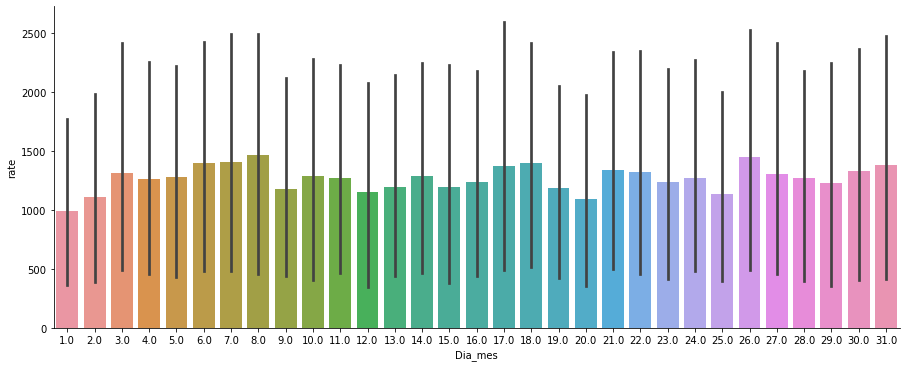

In [461]:

info_dia_mes=pd.pivot_table(data=datos,index=['Dia_mes','ao_hechos'],values='ao_inicio',aggfunc='count',fill_value=0)
info_dia_mes=info_dia_mes.reset_index()
info_dia_mes.index=info_dia_mes.Dia_mes
info_dia_mes=info_dia_mes.join(pesos)
info_dia_mes['rate']=info_dia_mes['ao_inicio']*info_dia_mes['pesos']
sns.catplot(data=info_dia_mes,x='Dia_mes',y='rate',kind='bar',aspect=2.5)

In [465]:
info_dia_mes.groupby('Dia_mes').mean()['rate'].sort_values(ascending=False)

Dia_mes
8.0     1465.285714
26.0    1450.357143
7.0     1408.275862
18.0    1400.620690
6.0     1394.896552
31.0    1378.224490
17.0    1375.000000
21.0    1335.833333
30.0    1328.832845
22.0    1324.129032
3.0     1317.129032
27.0    1305.612903
10.0    1286.151515
14.0    1283.718750
5.0     1279.090909
11.0    1272.937500
24.0    1269.903226
28.0    1267.062500
4.0     1258.696970
23.0    1237.151515
16.0    1237.090909
29.0    1228.633333
13.0    1196.235294
15.0    1191.205128
19.0    1186.411765
9.0     1178.411765
12.0    1151.111111
25.0    1135.314286
2.0     1110.083333
20.0    1091.487179
1.0      994.340000
Name: rate, dtype: float64

**Observaciones.**

Graficamente no  parece haber tendencia estacional en días de quincena o número de semana en concreto.


## Análisis de correspondencia 
Responder si hay algún delito característico de cada alcaldía, puede ser más complejo de lo que se piensa ya que el número de delitos cometidos en una alcaldía puede ser en general mayor que al de las demás por citar un ejemplo:
En general dificilimente un delito se cometera con menos frecuencia en Iztapalapa que en Milpa Alta, pero esto no quiere decir que en Milpa Alta no exista  un delito "característico" de la alcaldía, es decir el delito en cada alcaldía debe ser ponderado de acuerdo al número de delitos que se reportan en ella. En la siguiente imagen se puede observar un mapa de calor donde los rectangulos blancos indican que una delegación destaca en el reporte de cierto tipo de delito , observe como la delegación Milpa Alta es, le corresponde un renglon que es en la mayor parte opaco. Note también que los delitos en los que parece destacar una delegación puede tratarse de delitos con baja ocurrencia por lo que no nos podemos fiar solo del mapa de calor.

In [466]:
#Creamos la tabla de correspondencia
alcaldia_delito=pd.pivot_table(data=datos,index='alcaldia_hechos',columns='delito'
                               ,values='ao_inicio',aggfunc='count',fill_value=0)

In [548]:
sum_delito=alcaldia_delito.sum(axis=0)
sum_alcaldia=alcaldia_delito.sum(axis=1)
A=alcaldia_delito/sum_delito
B=(alcaldia_delito.T/sum_alcaldia).T

<AxesSubplot:xlabel='delito', ylabel='alcaldia_hechos'>

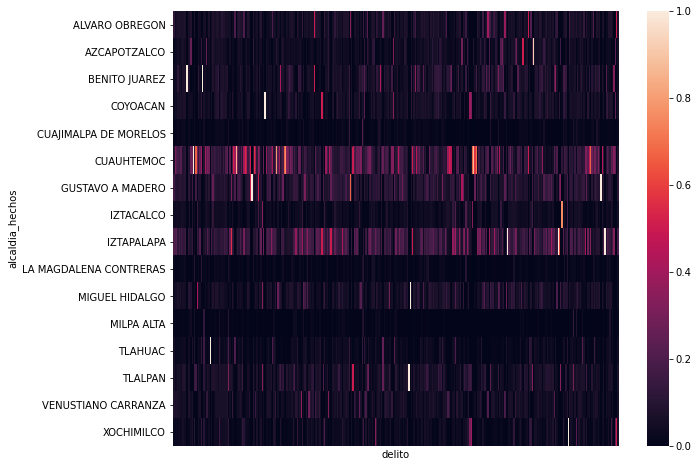

In [530]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(A,ax=ax,xticklabels=[])

Por otro lado los delitos con mayor ocurrencia tenderan a parececr característicos en más alcaldías, por ejemplo, en el siguiente mapa de calor se observan solo alguna lineas color purpura, lo cuál indican delitos que se cometen regularmente en todas las alcaldías.

<AxesSubplot:xlabel='delito', ylabel='alcaldia_hechos'>

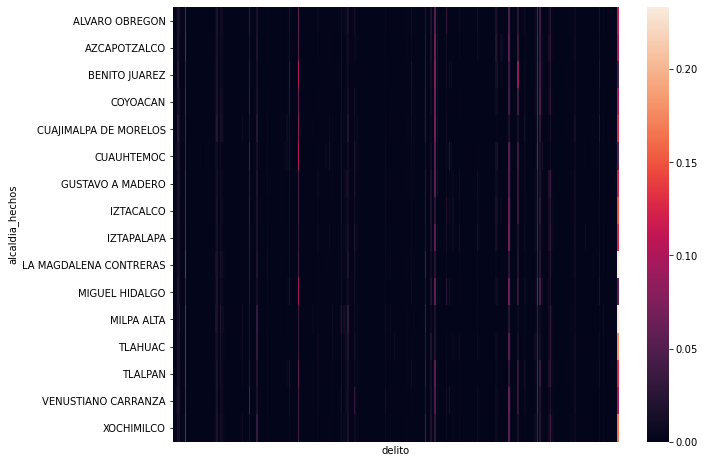

In [529]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(B,xticklabels=[])


In [573]:
A.shape

(16, 344)

En general se deben buscar delitos que aparezcan en todas las delegaciones y que sean suficientemente representativos para cierta alcaldía, es por eso que nos apoyaremos en la técnica de análisis de correspondencia.

Análisis de correspondencia mapea los distintos valores de nuestras variables categóricas (16 alcaldías y 344 tipos de delitos) en un espacio cartesiano multidimensional. En este caso buscaremos las 6 coordenadas principales, de cada alcaldía y de cada tipo de delito, para después realizar una asociación alcaldía-delito mediante el cirterio del vecion más cercano.

In [543]:
#Instanciamos nuestro análisis de correspondencia
ca=prince.CA(n_components=6)

In [550]:
# Encontramos las coordenadas de nuestras alcaldías y delitos
ca.fit(alcaldia_delito)
row_coordinates=ca.row_coordinates(alcaldia_delito)
column_coordinates=ca.column_coordinates(alcaldia_delito)

In [547]:
sum(ca.explained_inertia_)

0.8668737462670014

In [576]:
#Buscamos los tres delitos más cercanos a cada alcaldía
neigh = NearestNeighbors(n_neighbors=3, radius=0.4)
neigh.fit(column_coordinates)
_,indice=neigh.kneighbors(row_coordinates)

In [583]:
#Los primeros 3 delitos característicos de cada alcaldía son
crimen_carac_1=pd.DataFrame({'Crimen Característico1':column_coordinates.index[indice[:,0]],
                             'Crimen Característico2':column_coordinates.index[indice[:,1]],
                             'Crimen Característico3':column_coordinates.index[indice[:,2]]},
                            index=row_coordinates.index)
crimen_carac_1

,Crimen Característico1,Crimen Característico2,Crimen Característico3
ALVARO OBREGON,PRIV. ILEGAL DE LA LIB. Y ROBO DE VEHICULO,DAÑO EN PROPIEDAD AJENA CULPOSA POR TRÁNSITO V...,DAÑO EN PROPIEDAD AJENA INTENCIONAL A AUTOMOVIL
AZCAPOTZALCO,PERDIDA DE LA VIDA POR ACCIDENTE LABORAL,ROBO A NEGOCIO CON VIOLENCIA POR FARDEROS (TIE...,LESIONES CULPOSAS ACCIDENTE LABORAL
BENITO JUAREZ,FALSIFICACION DE TITULOS AL PORTADOR Y DOCUMEN...,ROBO DE ACCESORIOS DE AUTO,"PRODUCCIÓN, IMPRESIÓN, ENAJENACIÓN, DISTRIBUCI..."
COYOACAN,DAÑO EN PROPIEDAD AJENA CULPOSA POR TRÁNSITO V...,PERDIDA DE LA VIDA POR CAIDA,DAÑO EN PROPIEDAD AJENA CULPOSA POR TRÁNSITO V...
CUAJIMALPA DE MORELOS,LESIONES CULPOSAS POR QUEMADURAS,QUEBRANTAMIENTO DE SELLOS,ATAQUE A LAS VIAS DE COMUNICACION (DAÑO A VIAS...
CUAUHTEMOC,FALSIFICACION O ALTERACION Y USO INDEBIDO DE D...,DISCRIMINACION,INSOLVENCIA ALIMENTARIA
GUSTAVO A MADERO,TENTATIVA DE ROBO DE VEHICULO,TENTATIVA DE EXTORSION,SUSTRACCION DE MENORES
IZTACALCO,PERDIDA DE LA VIDA ASFIXIA POR ALIMENTOS/ LIQU...,TENTATIVA DE ROBO,ATAQUE A LAS VIAS GENERALES DE COMUNICACIÓN
IZTAPALAPA,ROBO A PASAJERO / CONDUCTOR DE TAXI CON VIOLENCIA,ROBO A REPARTIDOR SIN VIOLENCIA,HOMICIDIO POR ARMA DE FUEGO
LA MAGDALENA CONTRERAS,VIOLACION EQUIPARADA POR CONOCIDO,ESTUPRO,ROBO DE ANIMALES


En la primer columna de la base anterior se muestra el delito más cercano a cada alcaldía, podemos notar que en cadda el delito delegación es diferente, hecho que no sucede en la segunda columna, donde comienzan a repetrise delitos. En la siguiente gráfica se muestran las primeras dos coordenadas de cada alacaldía, donde  la cercania entre puntos  puede indicar que los delitos que suelen cometerse son repetidas veces del mismo tipo.  

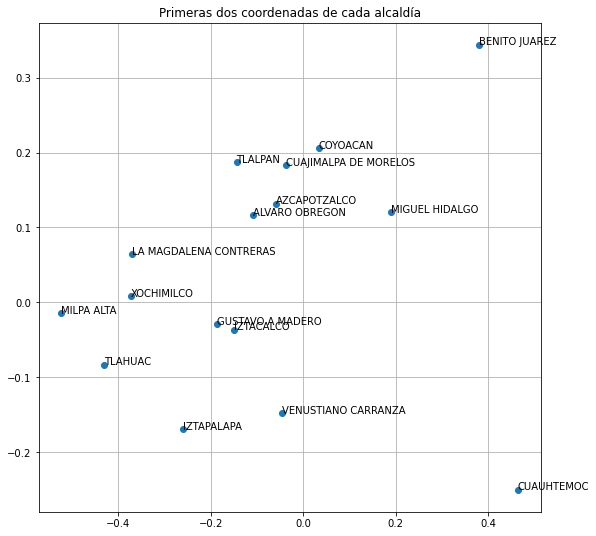

In [584]:
f = plt.subplots(figsize=(9, 9))
plt.scatter(row_coordinates.iloc[:,0],row_coordinates.iloc[:,1])
plt.grid()
plt.title('Primeras dos coordenadas de cada alcaldía')
for i,alcal in enumerate(row_coordinates.index): 
    plt.text(row_coordinates.iloc[i,0],row_coordinates.iloc[i,1],s=alcal)

## Indicador nivel de seguridad

Para este punto utilizaremos un análisis de factores que nos ayude a argupar las variables (tipod de delitos) en un subconjunto menor de variables en este caso serán 12, posteriormente análisamos los pesos de las variables en cada componenete con el objetivo de determinar una ponderación adecuada de acuerdo al tipo de delito que forman parte de cada grupo de variables (este paso puede ser un poco tardado y subjetivo por lo que solo usaremos un promedio simple de los datos transformados). Por simplicidad crearemos el indicador a nivel calle, tomando la varaible **calle_hecho** como dato muestral.

In [585]:
#Creamos matriz que decompondremos
calle_delito=pd.pivot_table(data=datos,index='calle_hechos',columns='delito'
                               ,values='ao_inicio',aggfunc='count',fill_value=0)

In [596]:
#Realizamos transformación
transformer = FactorAnalysis(n_components=12, random_state=0)
X_transformed = transformer.fit_transform(calle_delito)

In [607]:
#Analizamos las variables con mayor magnitud en cada componente
componentes=pd.DataFrame(transformer.components_.T,index=calle_delito.columns,columns=[str(a)+'_c' for a in range(12)])

In [618]:
componentes['0_c'].sort_values(ascending=False)[:20]

delito
ROBO A NEGOCIO SIN VIOLENCIA                                            3.724727
FRAUDE                                                                  3.594284
ROBO DE OBJETOS                                                         2.719243
VIOLENCIA FAMILIAR                                                      2.493297
ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA                          2.111481
DENUNCIA DE HECHOS                                                      1.866022
AMENAZAS                                                                1.656678
ROBO DE OBJETOS DEL INTERIOR DE UN VEHICULO                             1.008986
FALSIFICACION DE TITULOS AL PORTADOR Y DOCUMENTOS DE CREDITO PUBLICO    0.989552
DAÑO EN PROPIEDAD AJENA CULPOSA POR TRÁNSITO VEHICULAR A AUTOMOVIL      0.805413
ROBO DE ACCESORIOS DE AUTO                                              0.767994
ROBO A NEGOCIO CON VIOLENCIA                                            0.726558
ABUSO DE CONFIANZA   

In [634]:
#Obtenemmos indicador
indicador=np.mean(X_transformed,axis=1)
#Estádarizamos entre cero y uno
ind_min=min(indicador)
ind_max=max(indicador)

indicador=(indicador-ind_min)/(ind_max-ind_min)
#Volvemos data frame para realizar un cruze 
indicador=pd.DataFrame(indicador,index=calle_delito.index,columns=['value'])

In [635]:
datos.index=datos.calle_hechos

In [636]:
indicador_ext=indicador.join(datos[['longitud', 'latitud']])


<AxesSubplot:title={'center':'Nivel de inseguridad muestra de 2000 zonas'}, xlabel='longitud', ylabel='latitud'>

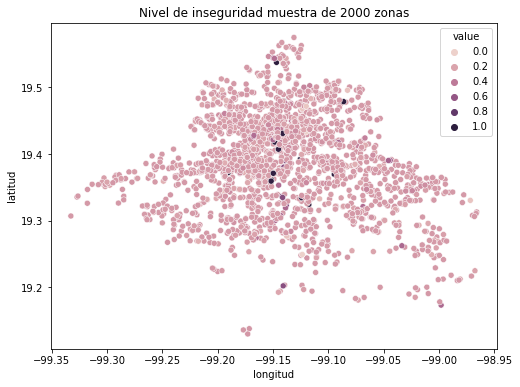

In [653]:
f, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Nivel de inseguridad muestra de 2000 zonas')
sns.scatterplot(data=indicador_ext.sample(2000),x='longitud',y='latitud',hue='value',ax=ax)

En general el nivel de inseguridad para estar oscilando entre $0.2$ y $0.4$ lo que da pauta a que se puedan realizar investigaciones  enfocadas solo en las calles con un nivel de inseguridad que este entre $0.8$ y $1$, ya que al parecer son minoría. 